<h2> Data and Library Import </h2>

In [2]:
import sys
import networkx as nx 
import graphviz
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dowhy import CausalModel
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)



In [3]:
df = pd.read_csv("../data/processed/data.csv")

In [4]:
df.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,price,freight_value,payment_value,Rating,review_creation_date,review_answer_timestamp,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_x,geolocation_lng_x,geolocation_lat_y,geolocation_lng_y,month,product_category_name_encoded,seller_id_encoded,rainfall,product_weight_kg,product_size,no_photos,product_price,late_delivery_in_days,is_delivery_late,distance_km,customer_experience,seller_avg_rating
0,d455a8cb295653b55abda06d434ab492,944b72539d7e1f7f7fc6e46639ef1fe3,delivered,2017-09-26 22:17:05,2017-09-27 22:24:16,2017-10-07 16:12:47,2017-10-30,1.0,a2ff5a97bf95719e38ea2e3b4105bce8,0015a82c2db000af6aaaf3ae2ecb0532,895.0,21.02,916.02,5.0,2017-10-08,2017-10-11 21:42:45,eletroportateis,2.0,11800.0,40.0,43.0,36.0,3c7e305796add66698959fc7ad176f6b,87502,umuarama,PR,9080.0,santo andre,SP,-23.759416,-53.292784,-23.640444,-46.541742,9,31,0,South,11.8,61920.0,2.0,895.0,-23,0,687.434185,5.0,5.0


In [5]:
nodes_list = [
'Rating',
'product_category_name_encoded',
'freight_value',
'distance_km',
'month',
'is_delivery_late'
]

df[nodes_list].isnull().sum()

Rating                           0
product_category_name_encoded    0
freight_value                    0
distance_km                      0
month                            0
is_delivery_late                 0
dtype: int64


<h2>EDA</h2>

Let's examine the distribution of our variables. 
Since we are examining the relationship between ratings and is_delivery_late, let's take a look at those. 

<b>1.   Distribution of Ratings in the dataset</b>

Rating is an ordinal variable that ranges from 1-5 with 1 being the lowest and 5 being the highest rating a customer could leave.

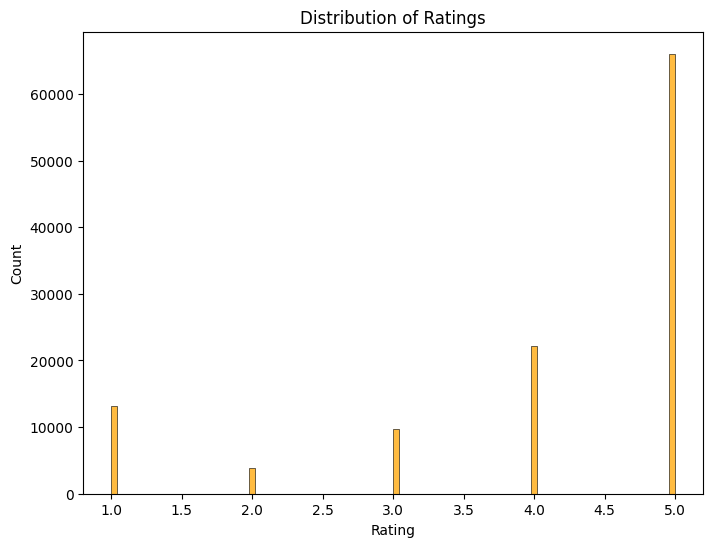

In [6]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Rating', palette='coolwarm', color='orange')
plt.title(f'Distribution of Ratings')
plt.show()

The data features 5 starred product ratings the most, followed by 4 and 1 star. 

<b>2. Distribution of Is_delivery_late</b>

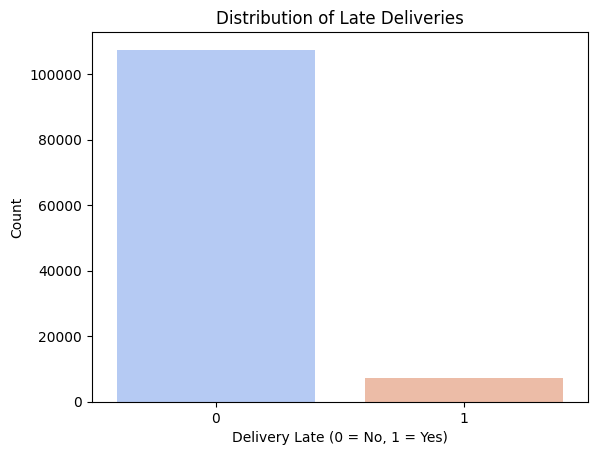

In [7]:
# Plotting the distribution of 'is_delivery_late'
sns.countplot(x='is_delivery_late', data=df, palette='coolwarm')

# Adding labels and title
plt.xlabel('Delivery Late (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.title('Distribution of Late Deliveries')
plt.show()

Most of the data was not delivered late.

In [12]:
print(np.sum(df['is_delivery_late']==1))
print(np.sum(df['is_delivery_late']==0))

7368
107473


We have about ~100K cases when the delivery was on time, while the delivery was late for about 7400 cases. 

<h3><li>Correlation Analysis</li></h3>

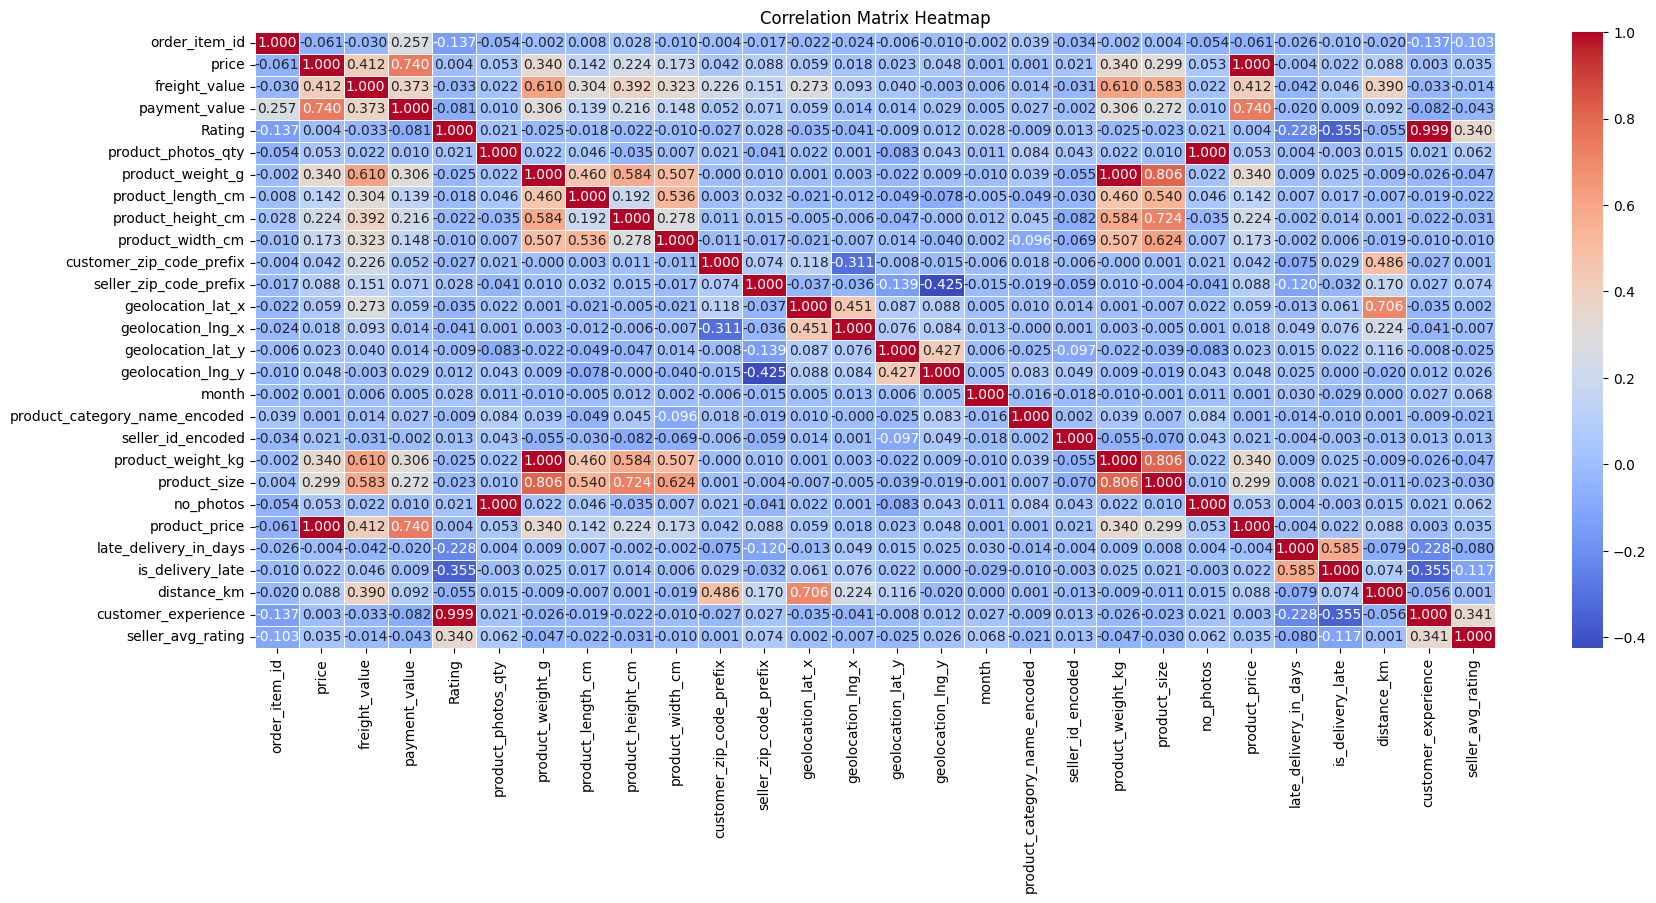

In [9]:
# Extract numerical columns
numerical_df = df.select_dtypes(include=['number'])

# Run correlation analysis
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(20,8))  # Optional: Adjust the figure size
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Correlation Analysis shows that -
<ul><li> A moderate correlation between ratings and is_delivery_late </li>
<li>A strong correlation between rating and customer experience is expected since customer_experience is an average of the past 5 ratings (for any product) left by the customers.</li>
<li>Rating also related slighly to the seller rating</li>
<li>Freight_value is also correlated with product_weight and product_size</li>

<h3><li>Chi-Squared Test of Independence</li></h3>

In [10]:
# Create a contingency table
contingency_table = pd.crosstab(df['is_delivery_late'], df['Rating'])

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:\n", expected)

# Interpretation of results
if p < 0.05:
    print("There is a significant association between delivery delays and customer ratings.")
else:
    print("There is no significant association between delivery delays and customer ratings.")


Chi-Square Statistic: 16075.010956826085
P-value: 0.0
Degrees of Freedom: 4
Expected Frequencies Table:
 [[12277.30764274  3647.91105964  9030.87268484 20727.9584556
  61788.95015717]
 [  841.69235726   250.08894036   619.12731516  1421.0415444
   4236.04984283]]
There is a significant association between delivery delays and customer ratings.


<h3><li>Regression Analysis</li></h3>

Since is_delivery_late is a binary variable, we can run a binary logistic regression. 

Rating or Review score is an ordinal variable (varies from 1-5). We try to run an ordinal logistic regression in order to account for the ordering of the ratings and the fact that the difference between them cannot be treated as mathematical. 


<b>1. Simple Linear Regression</b>

While we are aware that rating is an ordinal variable, we can use SLR as a benchmark for the rest of our methodology. 

In [11]:
# Assuming 'df' is your dataframe
# Define the dependent variable (Y) as 'Rating' (the numerical variable)
Y = df['Rating']

# Define the independent variable (X) as 'is_delivery_late' (the binary variable)
X = df['is_delivery_late']

# Add a constant to the independent variable to account for the intercept
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)
results = model.fit()

# Print the summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                 1.655e+04
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:35:20   Log-Likelihood:            -1.8949e+05
No. Observations:              114841   AIC:                         3.790e+05
Df Residuals:                  114839   BIC:                         3.790e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.2055      0.004  

The R-squared is 12.6% and the coefficient of is_delivery_late is -1.95 which means that ratings go down by 1.87 stars if a particular order is late. <br>

This is by no means an accurate measure of the effect because it operates under the assumption that 'Rating' is a numerical variable. Additionally, it does not account for any confounding factors. This approach however, is used to benchmark the impact of our independent variable on our dependent variable. 

<b>2. Ordinal Linear Regression</b>

In [12]:
# Ensure Rating is treated as categorical with ordering
df['Rating'] = pd.Categorical(df['Rating'], categories=[1, 2, 3, 4, 5], ordered=True)

# Define the dependent variable (Y) as 'Rating'
Y = df['Rating']

# Define the independent variable (X) as 'is_delivery_late'
X = df[['is_delivery_late']]

# # Add a constant (intercept)
# X = sm.add_constant(X)

# Fit the ordinal logistic regression model
model = OrderedModel(Y, X, distr='logit')
result = model.fit(method='bfgs')

# Print the summary of the model
print(result.summary())


Optimization terminated successfully.
         Current function value: 1.159050
         Iterations: 19
         Function evaluations: 22
         Gradient evaluations: 22
                             OrderedModel Results                             
Dep. Variable:                 Rating   Log-Likelihood:            -1.3311e+05
Model:                   OrderedModel   AIC:                         2.662e+05
Method:            Maximum Likelihood   BIC:                         2.663e+05
Date:                Mon, 09 Dec 2024                                         
Time:                        15:35:49                                         
No. Observations:              114841                                         
Df Residuals:                  114836                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

Coefficient for is_delivery_late (-2.4590):A negative coefficient indicates that late deliveries are associated with lower ratings. Specifically, for a one-unit increase in is_delivery_late (from on-time to late), the log odds of a higher rating decreases by approximately 2.46.

These thresholds represent the boundaries between the different rating categories (1, 2, 3, 4, 5). They allow the model to distinguish between adjacent rating levels.
Each threshold separates the probability of getting a rating below a certain value from a rating above that value.

Delivery delays have a significant and negative impact on customer ratings. The model suggests that when a delivery is late, it significantly decreases the odds of a higher rating.

----